### Ćwiczenie 6
Zaobserwuj działanie następujących przekształceń punktowych:
1. Mnożenie obrazu przez stałą
2. Transformacja logarytmiczna
3. Zmiana dynamiki skali szarości (kontrastu)
4. Korekcja gamma

In [1]:
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
import os

Załadowanie wyznaczonych plików:

In [17]:
# Załadowanie pliku .tiff
img_a = tiff.imread("src/pollen-dark.tif") 
img_b = tiff.imread("src/spectrum.tif") 
img_c  = tiff.imread("src/einstein-low-contrast.tif") 
img_d = tiff.imread("src/aerial_view.tif") 

Obrazy bazowe:

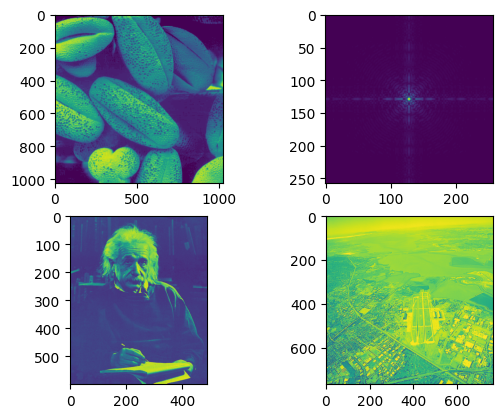

In [19]:
#Wyświetlenie załadowanego obrazu
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img_a)

plt.subplot(2,2,2)
plt.imshow(img_b)

plt.subplot(2,2,3)
plt.imshow(img_c)

plt.subplot(2,2,4)
plt.imshow(img_d)
plt.show()

## Funkcje przekształcające

Przyjmujemy że 'r', to nasz przetwarzany obraz <br>
*c* jest stałą podaną przez użytkownika 
1. T(r) = c*r
2. T(r) = c*log(1+r)
3. T(r) = 1/(1+(m/r)^e)<br>
    *m* oraz *e* są ustalonymi wartościami całkowitymi
4. T(r) = c*(r^gamma); gdzie c>0 oraz gamma>0

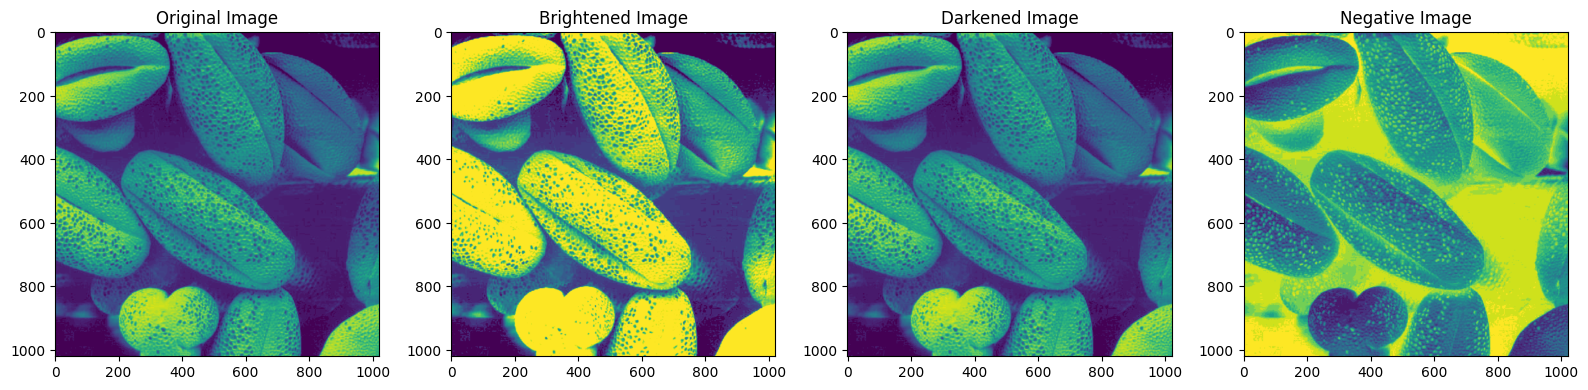

In [254]:

def TransformByConst(img, c=1.0, inv_factor=0.0):
    """
    Transform the image using a constant c.
    """
    max_val = np.iinfo(img.dtype).max
    transformed_img = c * img.astype(np.float32)
    inverted = max_val - transformed_img
    result = (1 - inv_factor) * transformed_img + inv_factor * inverted
    return np.clip(result, 0, max_val).astype(img.dtype)

#pollen-dark.tif
processing = img_a
plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(processing)
# rozjaśnienie
plt.subplot(1,4,2)
plt.title("Brightened Image")
img_an = TransformByConst(processing, c = 5.0)
plt.imshow(img_an)
# ściemienienie
plt.subplot(1,4,3)
plt.title("Darkened Image")
img_ab = TransformByConst(processing, c = 0.6)
plt.imshow(img_ab)
# negatyw
plt.subplot(1,4,4)
plt.title("Negative Image")
img_ac = TransformByConst(processing, c = 1.0, inv_factor = 0.6)
plt.imshow(img_ac)
plt.tight_layout()
plt.show()

### 1. Przekształcenie przez stałą
Przekształcenie przy pomocy mnożenia przez stałą pozwala na zwiększenie (wartości > 1) lub zmniejszenie (wartości w zakresie (0,1) ) jasności obrazu.<br>
Mnożenie przez liczby ujemne daje obraz negatywowy gdize szarości odwrócone są liniowo.


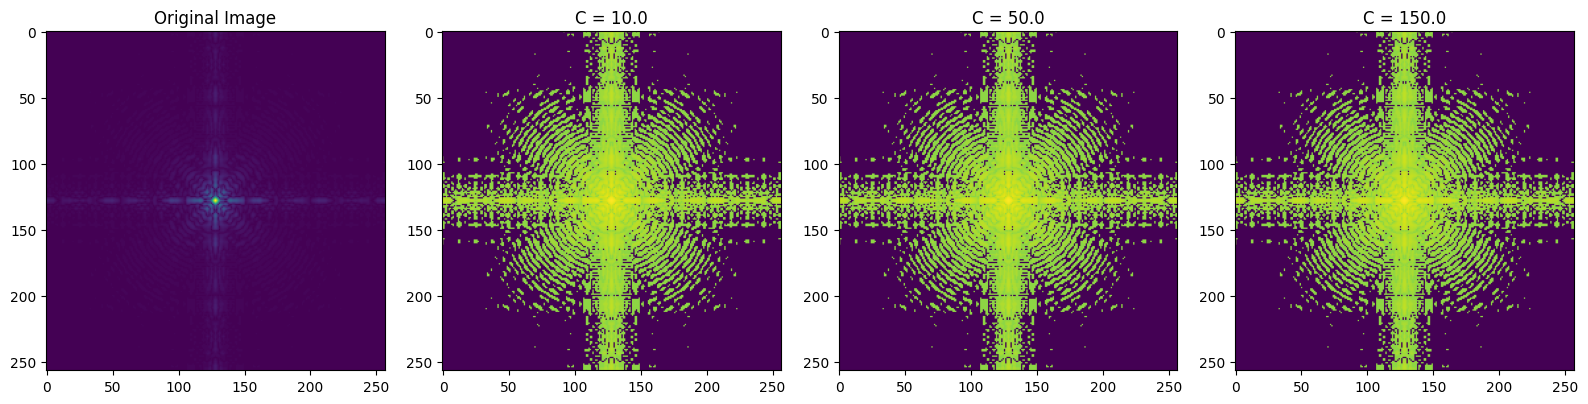

In [255]:
def LogarithmicTransform(img, c):
    """
    Apply logarithmic transformation to the image.
    """
    img_float = img.astype(np.float32)  + 1e-9 # Avoid log(0)
    return c * np.log(img_float)  # Apply log only to positive values

#spectrum.tif
processing = img_b
plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(processing)

plt.subplot(1,4,2)
img_ba = LogarithmicTransform(processing, c = 10.0)
plt.title("C = 10.0")
plt.imshow(img_ba)

plt.subplot(1,4,3)
img_bb = LogarithmicTransform(processing, c = 50.0)
plt.title("C = 50.0")
plt.imshow(img_bb)

plt.subplot(1,4,4)
img_bc = LogarithmicTransform(processing, c = 150.0)
plt.title("C = 150.0")
plt.imshow(img_bc)
plt.tight_layout()
plt.show()

### 2. Przekształcenie logarytmiczne
Przekształcenie logarytmiczne ma za zadanie wzmocnić ciemne obszary poprzez wzór - $T(r) = c · log (1 + r)$, gdzie $c = const$ <br> 
Przez wzgląd na działanie logarytmiczne $c > 0$

W wyniku badań, wartości $c=[10, 50, 150]$ nie przyniosły widocznych zmian


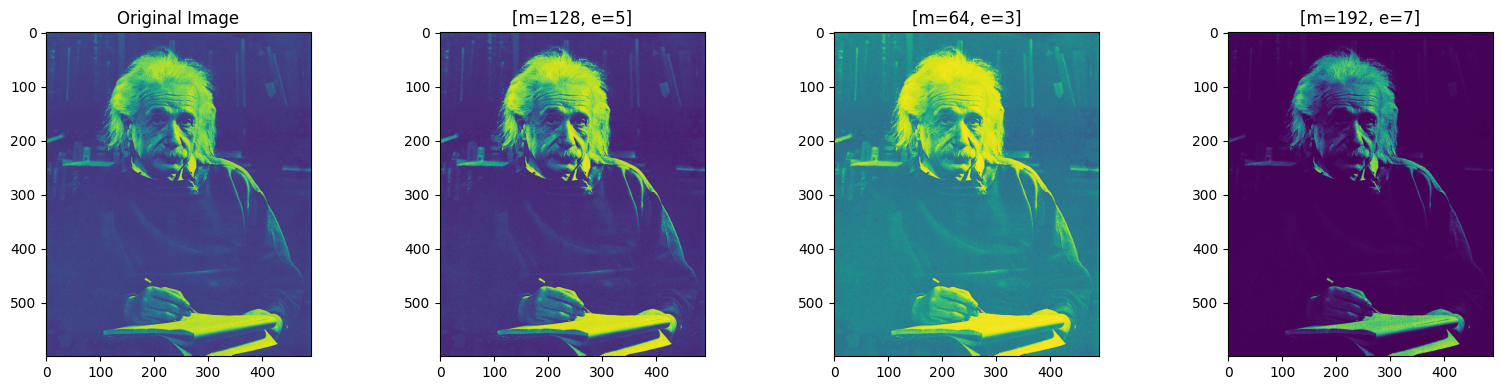

In [256]:
def GammaCorrection(img, m=1, e=1):
    """
    Apply contrast transformation to the image. Using formula:
    T(r) = 1/(1 + (m/img)^e)
    
    :param img: Input image
    :param m: Contrast factor
    :param e: Exponent factor (default is 1)
    :return: Transformed image
    """
    img_float = img.astype(np.float32) + 1e-9  # Avoid division by zero
    transformed_img = 1 / (1 + (m / img_float) ** e)
    return np.clip(transformed_img * 255, 0, 255).astype(np.uint8)

# einstein-low-contrast.tif
processing = img_c
plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(processing)

plt.subplot(1,4,2)
img_ca = GammaCorrection(processing, m = 128, e = 5)
plt.title("[m=128, e=5]")
plt.imshow(img_ca)

plt.subplot(1,4,3)
img_cb = GammaCorrection(processing, m = 64, e = 3)
plt.title("[m=64, e=3]")
plt.imshow(img_cb)

plt.subplot(1,4,4)
img_cc = GammaCorrection(processing, m = 192, e = 7)
plt.title("[m=192, e=7]")
plt.imshow(img_cc)
plt.tight_layout()
plt.show()

### 3. Przekształcenie Sigmoid (odwrotność funkcji potęgowej)
Przekształcenie to przy pomocy parametrów $m$ oraz $e$ zmieniają kontrast na podstawie wybranego poziomu szarości<br>
$m$ odpowiada za poziom szarości wokół którego następuje szybka zmiana kontrastu, natomiast $e$ definiuje stromość czyli kontrast


W celu przeprowadzenia badań wybrano wartości
- m=128, e=5.0<br>
Obraz z podwyższonym kontrastem wokół średniej szarości. Ciemne stają się cemniejsze, jasne jaśniejsze.
- m=64, e=3.0<br>
Próg przesunięty w stronę ciemnych tonów.
- m=192, e=7.0<br>
Próg przesunięty w stronę ajnsych tonów, bardzo ostry kontrast.

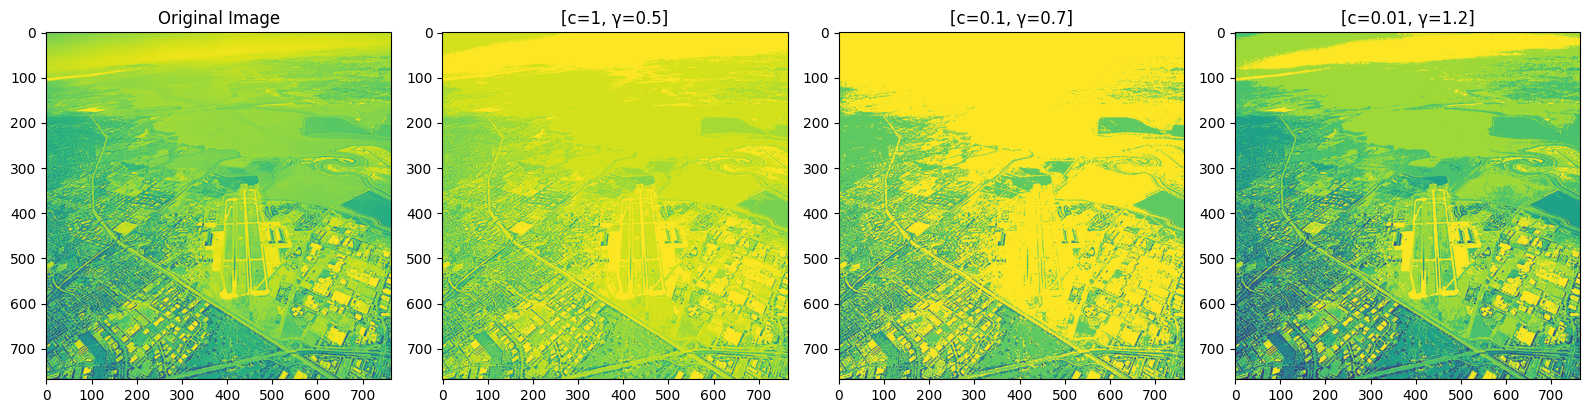

In [257]:
def GammaCorrection(img, c=1, γ=1):
    """
    Apply gamma correction to the image. Using formula:
    s = c * (r ** γ)
    where s is the output pixel value, r is the input pixel value, c is a constant, and γ is the exponent.
    
    :param img: Input image
    :param c: Constant factor (default is 1)
    :param γ: Exponent factor (default is 1)
    :return: Transformed image
    """
    img_float = img.astype(np.float32) + 1e-9  # Avoid division by zero
    transformed_img = c * (img_float ** γ)
    return np.clip(transformed_img, 0, 255).astype(np.uint8)

#aerial_view.tif
processing = img_d
plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(processing)

plt.subplot(1,4,2)
img_da = GammaCorrection(processing, c=1, γ=0.5)
plt.title("[c=1, γ=0.5]")
plt.imshow(img_da)

plt.subplot(1,4,3)
img_db = GammaCorrection(processing, c=0.1, γ=0.7)
plt.title("[c=0.1, γ=0.7]")
plt.imshow(img_db)

plt.subplot(1,4,4)
img_dc = GammaCorrection(processing, c=0.01, γ=1.2)
plt.title("[c=0.01, γ=1.2]")
plt.imshow(img_dc)
plt.tight_layout()
plt.show()

### 4. Konwersja gamma
Przekształcenie to przy pomocy parametrów $c$ oraz $γ$ zmieniają kontrast lub jasność obrazu<br>

W celu przeprowadzenia badań wybrano wartości
- c=1, γ=0.5<br>
Obraz został wyraźnie rozjaśniony. Wartość $γ < 0$ powoduje, że ciemne piksele stają się jaśniejsze. Cienie są podbite.
- c=0.1, γ=0.7<br>
Z powodu niskiego współczynika $c$ obraz jest przyciemniony pomimo wartości $γ<0$, dzięki temu cienie są tylko nieznacznie podbite.
- c=0.01, e=1.2<br>
Silnie przyciemniony obraz z przyciemnieniem jasnych obszarów